# Initial EDA of the Yelp Dataset
The purpose of this notebook is to do a high-level overview of the different data tables provided in the yelp dataset. We will perform initial cleaning and analysis of each of the provided tables.

In [1]:
# standard library
import codecs
import os
import re
import sys
import warnings
from pathlib import Path

# 3rd party
import googlemaps as gmaps
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import datetime as dt
from google.cloud import storage
import ftfy

import matplotlib.pyplot as plt

In [2]:
# set pandas viewing params
pd.set_option('display.max_columns', 60)

# ignore warnings (i.e., value set on copy/slice of df)
warnings.filterwarnings('ignore')

In [3]:
# project config variables
BUCKET_NAME = 'YOUR-BUCKET'
INPUT_BUCKET_PREFIX = 'YOUR/DIRECTORIES/'
OUTPUT_BUCKET_PATH = 'YOUR/DIRECTORIES/'
URI_PREFIX = 'gs://'
ROOT_DIR = Path.cwd().parent

In [4]:
%load_ext autoreload
%autoreload 2

# add src library to module path
sys.path.append(str(ROOT_DIR))

In [5]:
# import modules from src
from src.utils import to_snake_case, clean_byte_unicode_chars, fix_encoding

# import secrets
from creds import API_KEY

In [6]:
# instantiate GCS client
gcs_client = storage.Client()
# get project bucket metadata 
bucket = gcs_client.get_bucket(BUCKET_NAME)

In [7]:
# fetch blob paths from GCS
csv_bucket_paths = [blob.name for blob in bucket.list_blobs(prefix=INPUT_BUCKET_PREFIX)]
# convert blob paths to URIs
csv_bucket_paths = ['{}{}/{}'.format(URI_PREFIX, BUCKET_NAME, path) for path in csv_bucket_paths]
# yelp relational tables
datasets = ['business', 'checkin', 'review', 'tip', 'user']
# create dict of tables and paths
csv_path_dict = dict(zip(datasets, csv_bucket_paths))

In [ ]:
csv_path_dict

## Business

#### The business data includes information such as data, attributes and categories.

In [9]:
# read in the business data from GCS
df_business = pd.read_csv(csv_path_dict['business'])

In [10]:
print('The business data has {} rows and {} columns.'.format(df_business.shape[0], df_business.shape[1]))

The business data has 192609 rows and 60 columns.


In [11]:
#take a peek at the first few rows of data
df_business.head()

,hours,attributes.Open24Hours,attributes.Corkage,hours.Tuesday,hours.Monday,latitude,attributes.NoiseLevel,attributes.BikeParking,attributes.Caters,attributes.HasTV,stars,attributes.RestaurantsTakeOut,attributes.OutdoorSeating,attributes.WheelchairAccessible,attributes.BYOB,state,attributes.RestaurantsTableService,attributes.BestNights,attributes.ByAppointmentOnly,hours.Saturday,city,attributes.AcceptsInsurance,address,hours.Sunday,attributes.Smoking,attributes.DriveThru,attributes.BusinessAcceptsCreditCards,hours.Wednesday,attributes.CoatCheck,attributes.Ambience,attributes.RestaurantsGoodForGroups,attributes.BYOBCorkage,attributes.BusinessParking,name,attributes.Music,attributes.GoodForDancing,hours.Friday,attributes.RestaurantsAttire,attributes.RestaurantsReservations,longitude,attributes.WiFi,attributes.RestaurantsPriceRange2,hours.Thursday,is_open,attributes.HairSpecializesIn,attributes.GoodForKids,postal_code,attributes.HappyHour,categories,attributes.GoodForMeal,attributes.AgesAllowed,attributes.DietaryRestrictions,attributes.BusinessAcceptsBitcoin,review_count,attributes.RestaurantsDelivery,attributes.Alcohol,attributes.RestaurantsCounterService,attributes,attributes.DogsAllowed,business_id
0,NaN,NaN,NaN,NaN,NaN,33.522143,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,b'AZ',NaN,NaN,NaN,NaN,b'Phoenix',NaN,b'2818 E Camino Acequia Drive',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'Arizona Biltmore Golf Club',NaN,NaN,NaN,NaN,NaN,-112.018481,NaN,NaN,NaN,0,NaN,b'False',b'85016',NaN,"b'Golf, Active Life'",NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,{'GoodForKids': 'False'},NaN,b'1SWheh84yJXfytovILXOAQ'
1,"{'Saturday': '9:0-1:0', 'Sunday': '9:0-0:0', '...",NaN,NaN,b'9:0-0:0',b'9:0-0:0',43.605499,"b""u'loud'""",b'False',b'True',b'False',2.5,b'True',b'False',NaN,NaN,b'ON',b'True',NaN,NaN,b'9:0-1:0',b'Mississauga',NaN,b'30 Eglinton Avenue W',b'9:0-0:0',NaN,NaN,NaN,b'9:0-0:0',NaN,"b""{'romantic': False, 'intimate': False, 'clas...",b'True',NaN,"b""{'garage': False, 'street': False, 'validate...",b'Emerald Chinese Restaurant',NaN,NaN,b'9:0-1:0',"b""u'casual'""",b'True',-79.652289,"b""u'no'""",b'2',b'9:0-0:0',1,NaN,b'True',b'L5R 3E7',NaN,"b'Specialty Food, Restaurants, Dim Sum, Import...","b""{'dessert': False, 'latenight': False, 'lunc...",NaN,NaN,NaN,128,b'False',"b""u'full_bar'""",NaN,"{'BikeParking': 'False', 'GoodForMeal': ""{'des...",NaN,b'QXAEGFB4oINsVuTFxEYKFQ'
2,"{'Saturday': '17:30-22:0', 'Sunday': '17:30-21...",NaN,NaN,NaN,b'17:30-21:30',35.092564,"b""u'average'""",b'True',b'False',b'True',4.0,b'True',b'False',NaN,NaN,b'NC',b'True',NaN,NaN,b'17:30-22:0',b'Charlotte',NaN,"b'10110 Johnston Rd, Ste 15'",b'17:30-21:0',NaN,NaN,b'True',b'17:30-21:30',NaN,"b""{'romantic': False, 'intimate': False, 'tour...",b'True',NaN,"b""{'garage': False, 'street': False, 'validate...",b'Musashi Japanese Restaurant',NaN,NaN,b'17:30-22:0',"b""'casual'""",b'True',-80.859132,"b""u'no'""",b'2',b'17:30-21:30',1,NaN,b'True',b'28210',NaN,"b'Sushi Bars, Restaurants, Japanese'","b""{'dessert': False, 'latenight': False, 'lunc...",NaN,NaN,NaN,170,b'False',"b""u'beer_and_wine'""",NaN,"{'OutdoorSeating': 'False', 'BikeParking': 'Tr...",NaN,b'gnKjwL_1w79qoiV3IC_xQQ'
3,"{'Friday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",NaN,NaN,b'8:0-17:0',b'8:0-17:0',33.455613,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,b'AZ',NaN,NaN,NaN,NaN,b'Goodyear',NaN,"b'15655 W Roosevelt St, Ste 237'",NaN,NaN,NaN,NaN,b'8:0-17:0',NaN,NaN,NaN,NaN,NaN,b'Farmers Insurance - Paul Lorenz',NaN,NaN,b'8:0-17:0',NaN,NaN,-112.395596,NaN,NaN,b'8:0-17:0',1,NaN,NaN,b'85338',NaN,"b'Insurance, Financial Services'",NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,b'xvX2CttrVhyG2z1dFg_0xw'
4,"{'Saturday': '7:0-23:0', 'Sunday': '7:0-23:0',...",NaN,NaN,b'7:0-23:0',b'7:0-23:0',35.190012,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,b'NC',NaN,NaN,b'True',b'7:0-23:0',b'Charlotte',NaN,"b'4209 Stuart Andrew Blvd, Ste F'",b'7:0-23:0',NaN,NaN,b'True',b'7:0-23:0',NaN,NaN,NaN,NaN,NaN,b'Queen City Plumbing',NaN,NaN,b'7:0-23:0',NaN,NaN,-80.887223,NaN,NaN,b'7:0-23:0',1

In [12]:
# what types of data do we have and how many nulls?
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 60 columns):
hours                                    147779 non-null object
attributes.Open24Hours                   13 non-null object
attributes.Corkage                       662 non-null object
hours.Tuesday                            143428 non-null object
hours.Monday                             135767 non-null object
latitude                                 192609 non-null float64
attributes.NoiseLevel                    43879 non-null object
attributes.BikeParking                   85399 non-null object
attributes.Caters                        40628 non-null object
attributes.HasTV                         48098 non-null object
stars                                    192609 non-null float64
attributes.RestaurantsTakeOut            62077 non-null object
attributes.OutdoorSeating                54823 non-null object
attributes.WheelchairAccessible          19959 non-null object
attri

Looks like the 60 variables can be grouped into a few general groups: demographic, review info, operating hours, and additional attributes. Moreover, the fields with "."'s are created from our original nested json files and are mostly sparse as indicated by the non-null counts. 

Let's begin by looking at the first few rows to understand how the data looks and is structured.

The `attributes` and `hours` variables are just nested json representations of the normalized children columns (eg., `attributes.Open24Hours`) so we can safely drop these. 

In [13]:
df_business.drop(columns=['attributes', 'hours'], inplace=True)

Next, let's clean up these column names to be in snake case. Explain utility function from module...

In [14]:
df_business.columns = [to_snake_case(col) for col in df_business.columns]

Moreover, it looks like there was an encoding issue with the strings while converting from json to csv. This is indicated by the `b'`, `b"`, and `b"u'` characters prepended to the beginning of the values in each string column. These characters are used to indicate byte and unicode literals in Python and they have been included as part of our new string literals. It's most likely the case thhat we incorrectly encoded these strings as utf-8 when the encoding was something different (eg., latin-1).

In [15]:
df_business.head()

,attributes_open_24_hours,attributes_corkage,hours_tuesday,hours_monday,latitude,attributes_noise_level,attributes_bike_parking,attributes_caters,attributes_has_tv,stars,attributes_restaurants_take_out,attributes_outdoor_seating,attributes_wheelchair_accessible,attributes_byob,state,attributes_restaurants_table_service,attributes_best_nights,attributes_by_appointment_only,hours_saturday,city,attributes_accepts_insurance,address,hours_sunday,attributes_smoking,attributes_drive_thru,attributes_business_accepts_credit_cards,hours_wednesday,attributes_coat_check,attributes_ambience,attributes_restaurants_good_for_groups,attributes_byob_corkage,attributes_business_parking,name,attributes_music,attributes_good_for_dancing,hours_friday,attributes_restaurants_attire,attributes_restaurants_reservations,longitude,attributes_wi_fi,attributes_restaurants_price_range_2,hours_thursday,is_open,attributes_hair_specializes_in,attributes_good_for_kids,postal_code,attributes_happy_hour,categories,attributes_good_for_meal,attributes_ages_allowed,attributes_dietary_restrictions,attributes_business_accepts_bitcoin,review_count,attributes_restaurants_delivery,attributes_alcohol,attributes_restaurants_counter_service,attributes_dogs_allowed,business_id
0,NaN,NaN,NaN,NaN,33.522143,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,b'AZ',NaN,NaN,NaN,NaN,b'Phoenix',NaN,b'2818 E Camino Acequia Drive',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'Arizona Biltmore Golf Club',NaN,NaN,NaN,NaN,NaN,-112.018481,NaN,NaN,NaN,0,NaN,b'False',b'85016',NaN,"b'Golf, Active Life'",NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,b'1SWheh84yJXfytovILXOAQ'
1,NaN,NaN,b'9:0-0:0',b'9:0-0:0',43.605499,"b""u'loud'""",b'False',b'True',b'False',2.5,b'True',b'False',NaN,NaN,b'ON',b'True',NaN,NaN,b'9:0-1:0',b'Mississauga',NaN,b'30 Eglinton Avenue W',b'9:0-0:0',NaN,NaN,NaN,b'9:0-0:0',NaN,"b""{'romantic': False, 'intimate': False, 'clas...",b'True',NaN,"b""{'garage': False, 'street': False, 'validate...",b'Emerald Chinese Restaurant',NaN,NaN,b'9:0-1:0',"b""u'casual'""",b'True',-79.652289,"b""u'no'""",b'2',b'9:0-0:0',1,NaN,b'True',b'L5R 3E7',NaN,"b'Specialty Food, Restaurants, Dim Sum, Import...","b""{'dessert': False, 'latenight': False, 'lunc...",NaN,NaN,NaN,128,b'False',"b""u'full_bar'""",NaN,NaN,b'QXAEGFB4oINsVuTFxEYKFQ'
2,NaN,NaN,NaN,b'17:30-21:30',35.092564,"b""u'average'""",b'True',b'False',b'True',4.0,b'True',b'False',NaN,NaN,b'NC',b'True',NaN,NaN,b'17:30-22:0',b'Charlotte',NaN,"b'10110 Johnston Rd, Ste 15'",b'17:30-21:0',NaN,NaN,b'True',b'17:30-21:30',NaN,"b""{'romantic': False, 'intimate': False, 'tour...",b'True',NaN,"b""{'garage': False, 'street': False, 'validate...",b'Musashi Japanese Restaurant',NaN,NaN,b'17:30-22:0',"b""'casual'""",b'True',-80.859132,"b""u'no'""",b'2',b'17:30-21:30',1,NaN,b'True',b'28210',NaN,"b'Sushi Bars, Restaurants, Japanese'","b""{'dessert': False, 'latenight': False, 'lunc...",NaN,NaN,NaN,170,b'False',"b""u'beer_and_wine'""",NaN,NaN,b'gnKjwL_1w79qoiV3IC_xQQ'
3,NaN,NaN,b'8:0-17:0',b'8:0-17:0',33.455613,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,b'AZ',NaN,NaN,NaN,NaN,b'Goodyear',NaN,"b'15655 W Roosevelt St, Ste 237'",NaN,NaN,NaN,NaN,b'8:0-17:0',NaN,NaN,NaN,NaN,NaN,b'Farmers Insurance - Paul Lorenz',NaN,NaN,b'8:0-17:0',NaN,NaN,-112.395596,NaN,NaN,b'8:0-17:0',1,NaN,NaN,b'85338',NaN,"b'Insurance, Financial Services'",NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,b'xvX2CttrVhyG2z1dFg_0xw'
4,NaN,NaN,b'7:0-23:0',b'7:0-23:0',35.190012,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,b'NC',NaN,NaN,b'True',b'7:0-23:0',b'Charlotte',NaN,"b'4209 Stuart Andrew Blvd, Ste F'",b'7:0-23:0',NaN,NaN,b'True',b'7:0-23:0',NaN,NaN,NaN,NaN,NaN,b'Queen City Plumbing',NaN,NaN,b'7:0-23:0',NaN,NaN,-80.887223,NaN,NaN,b'7:0-23:0',1,NaN,NaN,b'28217',NaN,"b'Plumbing, Shopping, Local Services, Home Ser...",NaN,NaN,NaN,b'False',4,NaN,NaN,NaN,NaN,b'HhyxOkGAM07SRYtlQ4wMFQ'


We defined a function `clean_byte_unicode_chars` that uses regular expressions to search input text for each of the cases of incorrect byte and unicode identifiers we found and removes them. We apply tihs function to all object type columns containing strings.

In [16]:
# apply our cleaning function to each object column in the dataframe and assign back
for col in df_business.select_dtypes('object').columns:
    df_business[col] = df_business[col].apply(clean_byte_unicode_chars)

In [17]:
df_business.head()

,attributes_open_24_hours,attributes_corkage,hours_tuesday,hours_monday,latitude,attributes_noise_level,attributes_bike_parking,attributes_caters,attributes_has_tv,stars,attributes_restaurants_take_out,attributes_outdoor_seating,attributes_wheelchair_accessible,attributes_byob,state,attributes_restaurants_table_service,attributes_best_nights,attributes_by_appointment_only,hours_saturday,city,attributes_accepts_insurance,address,hours_sunday,attributes_smoking,attributes_drive_thru,attributes_business_accepts_credit_cards,hours_wednesday,attributes_coat_check,attributes_ambience,attributes_restaurants_good_for_groups,attributes_byob_corkage,attributes_business_parking,name,attributes_music,attributes_good_for_dancing,hours_friday,attributes_restaurants_attire,attributes_restaurants_reservations,longitude,attributes_wi_fi,attributes_restaurants_price_range_2,hours_thursday,is_open,attributes_hair_specializes_in,attributes_good_for_kids,postal_code,attributes_happy_hour,categories,attributes_good_for_meal,attributes_ages_allowed,attributes_dietary_restrictions,attributes_business_accepts_bitcoin,review_count,attributes_restaurants_delivery,attributes_alcohol,attributes_restaurants_counter_service,attributes_dogs_allowed,business_id
0,NaN,NaN,NaN,NaN,33.522143,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,AZ,NaN,NaN,NaN,NaN,Phoenix,NaN,2818 E Camino Acequia Drive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arizona Biltmore Golf Club,NaN,NaN,NaN,NaN,NaN,-112.018481,NaN,NaN,NaN,0,NaN,False,85016,NaN,"Golf, Active Life",NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,1SWheh84yJXfytovILXOAQ
1,NaN,NaN,9:0-0:0,9:0-0:0,43.605499,loud,False,True,False,2.5,True,False,NaN,NaN,ON,True,NaN,NaN,9:0-1:0,Mississauga,NaN,30 Eglinton Avenue W,9:0-0:0,NaN,NaN,NaN,9:0-0:0,NaN,"{'romantic': False, 'intimate': False, 'classy...",True,NaN,"{'garage': False, 'street': False, 'validated'...",Emerald Chinese Restaurant,NaN,NaN,9:0-1:0,casual,True,-79.652289,no,2,9:0-0:0,1,NaN,True,L5R 3E7,NaN,"Specialty Food, Restaurants, Dim Sum, Imported...","{'dessert': False, 'latenight': False, 'lunch'...",NaN,NaN,NaN,128,False,full_bar,NaN,NaN,QXAEGFB4oINsVuTFxEYKFQ
2,NaN,NaN,NaN,17:30-21:30,35.092564,average,True,False,True,4.0,True,False,NaN,NaN,NC,True,NaN,NaN,17:30-22:0,Charlotte,NaN,"10110 Johnston Rd, Ste 15",17:30-21:0,NaN,NaN,True,17:30-21:30,NaN,"{'romantic': False, 'intimate': False, 'touris...",True,NaN,"{'garage': False, 'street': False, 'validated'...",Musashi Japanese Restaurant,NaN,NaN,17:30-22:0,casual,True,-80.859132,no,2,17:30-21:30,1,NaN,True,28210,NaN,"Sushi Bars, Restaurants, Japanese","{'dessert': False, 'latenight': False, 'lunch'...",NaN,NaN,NaN,170,False,beer_and_wine,NaN,NaN,gnKjwL_1w79qoiV3IC_xQQ
3,NaN,NaN,8:0-17:0,8:0-17:0,33.455613,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,AZ,NaN,NaN,NaN,NaN,Goodyear,NaN,"15655 W Roosevelt St, Ste 237",NaN,NaN,NaN,NaN,8:0-17:0,NaN,NaN,NaN,NaN,NaN,Farmers Insurance - Paul Lorenz,NaN,NaN,8:0-17:0,NaN,NaN,-112.395596,NaN,NaN,8:0-17:0,1,NaN,NaN,85338,NaN,"Insurance, Financial Services",NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,xvX2CttrVhyG2z1dFg_0xw
4,NaN,NaN,7:0-23:0,7:0-23:0,35.190012,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NC,NaN,NaN,True,7:0-23:0,Charlotte,NaN,"4209 Stuart Andrew Blvd, Ste F",7:0-23:0,NaN,NaN,True,7:0-23:0,NaN,NaN,NaN,NaN,NaN,Queen City Plumbing,NaN,NaN,7:0-23:0,NaN,NaN,-80.887223,NaN,NaN,7:0-23:0,1,NaN,NaN,28217,NaN,"Plumbing, Shopping, Local Services, Home Servi...",NaN,NaN,NaN,False,4,NaN,NaN,NaN,NaN,HhyxOkGAM07SRYtlQ4wMFQ


It looks like we were successful in removing all the extra `b'`, `b"`, and `b"u'` characters, but if we do some more digging, we still have an issue with control characters. 

In [18]:
df_business.name.str.contains('\\', regex=False).sum()

2158

It appears that our escaped unicode characters are of the 2 digit hex form:

In [19]:
df_business.name[df_business.name.str.contains('\\', regex=False, na=False)].head(10)

309                     Flyjin Caf\xc3\xa9
384     Chez ma Grosse Truie Ch\xc3\xa9rie
387              Steak \xe2\x80\x99n Shake
392                 La Barista Caf\xc3\xa9
463    Jardin Botanique de Montr\xc3\xa9al
465                      Hoche Caf\xc3\xa9
532                         Ph\xc3\xb3 Lyn
565              Steak \xe2\x80\x99n Shake
709     B\xc3\xa1nh Cuon Thanh Tr\xc3\xbac
766               Big Tuna Pok\xc3\xa9 Bar
Name: name, dtype: object

Taking a closer look at just 1, we can see that when we unescape the unicode characters that our encoding is not correct. 

In [20]:
example = df_business.name[df_business.name.str.contains('\\', regex=False, na=False)].iloc[0]
example

'Flyjin Caf\\xc3\\xa9'

In [21]:
codecs.decode(example, 'unicode-escape')

'Flyjin CafÃ©'

Using the hex conversion table found [here](https://www.utf8-chartable.de/unicode-utf8-table.pl?start=128&number=128&utf8=string-literal&unicodeinhtml=hex), we can see that `\xc3\xa9` should render as é instead of Ã©. This is a pretty good indication that we have encoded our data with one standard and decoded with another, resulting in a nonsense character sequence referred to as mojibake. We create a function to decode the escaped character sequences and then use the ftfy package to fix our unicode for us. 

In [22]:
def fix_encoding(text):
    if text is not None:
        text = codecs.decode(text, 'unicode_escape')
        text = ftfy.fix_text(text)
    return text

Applying this function to our example, we can see that our function to fix encodings works as designed:

In [23]:
fix_encoding(example)

'Flyjin Café'

Next we check which columns containing strings have this issue with control characters:

In [24]:
df_business.select_dtypes(include='object').apply(lambda x: x.str.contains('\\', regex=False, na=False), axis=1).sum()

attributes_open_24_hours                       0
attributes_corkage                             0
hours_tuesday                                  0
hours_monday                                   0
attributes_noise_level                         0
attributes_bike_parking                        0
attributes_caters                              0
attributes_has_tv                              0
attributes_restaurants_take_out                0
attributes_outdoor_seating                     0
attributes_wheelchair_accessible               0
attributes_byob                                0
state                                          0
attributes_restaurants_table_service           0
attributes_best_nights                         0
attributes_by_appointment_only                 0
hours_saturday                                 0
city                                        6568
attributes_accepts_insurance                   0
address                                      722
hours_sunday        

Check before and after on city column to validate

In [25]:
# before fixing
df_business.city[df_business.city.str.contains('\\', regex=False, na=False)].value_counts()

Montr\xc3\xa9al                                       6449
Rosem\xc3\xa8re                                         18
Saint-J\xc3\xa9r\xc3\xb4me                              18
Ch\xc3\xa2teauguay                                      13
Sainte-Th\xc3\xa9r\xc3\xa8se                            11
Saint-L\xc3\xa9onard                                     8
Sainte-Ad\xc3\xa8le                                      8
Mont-Saint-Gr\xc3\xa9goire                               4
Montr\xc3\xa9al-Ouest                                    4
C\xc3\xb4te Saint-Luc                                    3
Montr\xc3\xa9al-Nord                                     3
Pr\xc3\xa9vost                                           2
Communaut\xc3\xa9-Urbaine-de-Montr\xc3\xa9al             2
C\xc3\xb4te-Saint-Luc                                    2
\xe2\x80\x8bChandler                                     1
Montr\xc3\xa9al (Qu\xc3\xa9bec)                          1
Montr\xc3\xa9al-Est                                     

In [26]:
# after fixing
df_business.city[df_business.city.str.contains('\\', regex=False, na=False)].apply(fix_encoding).value_counts()

Montréal                                6449
Rosemère                                  18
Saint-Jérôme                              18
Châteauguay                               13
Sainte-Thérèse                            11
Sainte-Adèle                               8
Saint-Léonard                              8
Mont-Saint-Grégoire                        4
Montréal-Ouest                             4
Côte Saint-Luc                             3
Montréal-Nord                              3
Communauté-Urbaine-de-Montréal             2
Côte-Saint-Luc                             2
Prévost                                    2
Ste-Dorothée                               1
Montréal (Québec)                          1
Québec                                     1
Île des Soeurs                             1
Sainte-thérèse                             1
Montréal-West                              1
Montéal                                    1
Sainte-Geneviève                           1
St-BenoÃ®t

NOTE: It's worth noting that we may have to do some cleanup of city names later on as there are many different variations of Montreal: Montréal, Montréal (Québec), Montrèal, etc.

In [27]:
# fix up the encodings in the city, address, and name field
df_business.city = df_business.city.apply(fix_encoding)
df_business.address = df_business.address.apply(fix_encoding)
df_business.name = df_business.name.apply(fix_encoding)

Let's continue by taking a look at all the non-sparse variable fields (neither an attribute nor hour field).

In [28]:
sparse_cols = (df_business.columns.str.startswith('attributes') | df_business.columns.str.startswith('hours'))

In [29]:
# look at field types of non-sparse fields
df_business.loc[:, ~sparse_cols].dtypes

latitude        float64
stars           float64
state            object
city             object
address          object
name             object
longitude       float64
is_open           int64
postal_code      object
categories       object
review_count      int64
business_id      object
dtype: object

In [30]:
# check distributions of numeric fields
df_business.loc[:, ~sparse_cols].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,latitude,stars,longitude,is_open,review_count
count,192609.000000,192609.000000,192609.000000,192609.000000,192609.000000
mean,38.541803,3.585627,-97.594785,0.823040,33.538962
std,4.941964,1.018458,16.697725,0.381635,110.135224
min,33.204642,1.000000,-115.493471,0.000000,3.000000
10%,33.427534,2.000000,-115.171130,0.000000,3.000000
25%,33.637408,3.000000,-112.274677,1.000000,4.000000
50%,36.144815,3.500000,-111.759324,1.000000,9.000000
75%,43.602989,4.500000,-79.983614,1.000000,25.000000
90%,43.870431,5.000000,-79.380365,1.000000,70.000000
max,51.299943,5.000000,-72.911982,1.000000,8348.000000


This shows us that stars can most likely include half scores like 4.5, roughly 82% of all businesses in our dataset are still open as of the time of the dataset release, and that businesses have been reviewed at least 3 times and up to 8,348 (but most are around 9).

In [31]:
# how many values are missing in the non-sparse fields
df_business.loc[:, ~sparse_cols].isnull().sum()

latitude            0
stars               0
state               0
city               28
address           420
name            22379
longitude           0
is_open             0
postal_code         0
categories       5011
review_count        0
business_id         0
dtype: int64

In [32]:
# are null values the only missing values or are there empty strings as well?
df_business.loc[:, ~sparse_cols].select_dtypes(include='object').apply(lambda x: x == '', axis=1).sum()

state             0
city              1
address        7682
name              0
postal_code     659
categories        0
business_id       0
dtype: int64

Only 4 fields have missing values: city, address, name, and categories. Of these, 3 are essentially related to the location itself, and we are not missing any coordinates (lat, long). So, we should be able to reverse geocode the locations via the lat, long pairs and get a good guess for what these missing values are with the Google Maps Geocoding API.

Before geocoding and doing a places lookup, we check if there is a reason why some of this data is missing. For example, are these locations all closed or do they all belong to a certain type of category?

We looked at the only record where city was an empty string.

In [33]:
df_business.loc[df_business.city == '', ~sparse_cols]

,latitude,stars,state,city,address,name,longitude,is_open,postal_code,categories,review_count,business_id
34070,33.338097,2.5,AZ,,,NSFC Strikers Soccer Complex,-111.677975,1,,"Soccer, Active Life",3,WpC53SqwoCY5AuYIFr_1eA


This location with city as an empty string also has address and postal code as an empty string. It has the minimum number of reviews in the dataset and is still open as of the time of release of the dataset. No obvious reason for values encoded as empty strings. It could be the case that this business was added by a user and not the business itself and that's why some of the information was not filled in.

In [34]:
# look at what number of businesses with addresses as empty strings are still open
df_business.loc[df_business.address == '', ~sparse_cols].is_open.value_counts()

1    7041
0     641
Name: is_open, dtype: int64

The vast majority of these are open (~91%). A sample gives a few insights as to whhy some of this information may be missing. Some businesses not specifying address information are mobile businesses that may not jhave phyhsical locations like the Dog walking service Gals Walking Pals or on-the-go party rental services like On the Go Casino. In fact, most of these businesses are some sort of home service withhout many reviews and are probably independently owned and operated without physical office addresses.

In [35]:
df_business.loc[df_business.address == '', ~sparse_cols].sample(n=20, random_state=42)

,latitude,stars,state,city,address,name,longitude,is_open,postal_code,categories,review_count,business_id
55972,33.445974,3.5,AZ,Mesa,,Desert Affects Landscaping,-111.803200,1,85203,"Shopping, Home Services, Home & Garden, Landsc...",5,csjErMBJ0_37s8nwMHqCgA
66999,33.498629,3.5,AZ,Scottsdale,,Cool Aid Air Conditioning LLC,-111.922440,1,85251,"Heating & Air Conditioning/HVAC, Home Services",5,I6KCFP4M9-uyuhc-RNa3sg
151694,33.627548,5.0,AZ,Phoenix,,Gals Walking Pals,-112.059560,1,85022,"Pet Services, Pets, Dog Walkers, Pet Sitting",46,2wM8aUN10f6OxM939Gfnog
130763,35.227087,5.0,NC,Charlotte,,Tailored Living Featuring Premier Garage,-80.843127,1,28277,"Shopping, Cabinetry, Home Services, Home Organ...",4,-fznkdpqpDmNTSHnn1yUfg
153597,43.115604,4.0,WI,Middleton,,General Purpose Movers,-89.530890,1,53562,"Home Services, Local Services, Packing Service...",12,ZJVXpUgLXpj4K09EV6tzgw
35546,33.266441,5.0,AZ,Chandler,,Stasis,-111.821087,1,85286,"Plumbing, Contractors, Home Services",3,Fa2HgUezekVzJUY7VifjKQ
12198,33.508094,3.5,AZ,Phoenix,,Auto Glass Now - Phoenix,-112.086387,1,85013,"Windshield Installation & Repair, Auto Glass S...",8,rPdomKMlNZJfNRQ0KE5S_w
189014,36.169710,5.0,NV,Las Vegas,,Rising Again Productions,-115.123695,1,89101,"Arts & Entertainment, Video/Film Production, E...",4,l4V5IK4v2YqfLrn2h7X7wg
128994,33.415130,4.0,AZ,Mesa,,Contact Restoration,-111.822979,1,85210,"Home Services, Damage Restoration, Local Servi...",7,TYcQdcn5zpW4HrCW_wEOkQ
192275,33.459458,5.0,AZ,Mesa,,On the Go Casino,-111.642224,1,85207,"Party & Event Planning, Party Equipment Rental...",9,HkrldtBqgnubiAh7gko9gw


A sample of businesses not specifying postal code information shows most of these businesses also don't specify business addresses, are missing names, and a large portion seem to be outside the US.

In [36]:
df_business.loc[df_business.postal_code == '', ~sparse_cols].sample(n=20, random_state=42)

,latitude,stars,state,city,address,name,longitude,is_open,postal_code,categories,review_count,business_id
182853,36.169941,5.0,NV,Las Vegas,,Classic Mobile Airbrush Tanning,-115.139830,0,,"Beauty & Spas, Day Spas, Spray Tanning, Eyelas...",35,Ul0EYexHUOptT9L2GUZJug
124224,36.039525,5.0,NV,Henderson,,Drustar Plumbing,-114.981721,1,,"Plumbing, Home Services",9,wQmgM4M-DMIJFQJ8hkNeKA
37704,36.175000,3.5,NV,Las Vegas,,Haulin Balls,-115.136389,0,,"Food Stands, Food, Restaurants, Street Vendors",31,YZ4P5I-OsQxVVoTENo1OAg
94885,45.508670,4.0,QC,Montréal,,Phoenix,-73.553993,1,,"Food Trucks, Restaurants, Food Stands, Food",4,peP56bWakpxPFuQ9QqsUPw
26219,43.467517,3.5,ON,Oakville,,None,-79.687666,1,,"Animal Shelters, Pets, Pet Services",6,NT9oIw3TTDLXo_x6nKUkBA
177693,45.508670,3.5,QC,Montréal,,Monsieur Crémeux,-73.553993,1,,"Food Trucks, Food",3,xMxK-3ZlhhCyEe9gvmhDkA
192021,43.639688,2.5,ON,Toronto,218 Queens Quay W,Shawarma Guys,-79.382766,1,,"Arabian, Restaurants, Middle Eastern",27,fJ43QHYmFf_EbfHqI97ptQ
69248,35.227087,3.0,NC,Charlotte,,Zaroob Food Truck,-80.843127,1,,"Middle Eastern, Chicken Shop, Food, Food Truck...",6,ge_6H0CdKEKEdnbWwrqzWQ
19950,33.494170,1.5,AZ,Scottsdale,,Strike Force Pest and Termite Control,-111.926052,1,,"Pest Control, Local Services",15,NqttSznYh5F4hB-g1fi3VA
179219,43.653226,5.0,ON,Toronto,,FoodVibrations,-79.383184,1,,"Personal Chefs, Event Planning & Services",4,Jkw9iBJrp4UBfEXspk-hAQ


Next we inspect records missing a city but have an address or business name. All the addresses except one are actually in Quebec, Canada. A quick google search shows most are in the same town: L'Île-Perrot. This makes sense as most of the lat long pairs look extremely close to each other and several are on the same streets given their address.

In [37]:
# any missing a city but have an address or business name?
df_business.loc[df_business.city.isnull(), ['name', 'city', 'state', 'postal_code', 'address', 'categories', 'latitude', 'longitude']]

,name,city,state,postal_code,address,categories,latitude,longitude
9772,Verger Labonte,None,QC,J7V 8P4,2291 Boul Perrot,"Specialty Food, Food, Fruits & Veggies",45.352407,-73.906460
15462,Pizza Hut,None,QC,H4L 2G7,None,"Pizza, Restaurants, Food, Food Delivery Servic...",45.513273,-73.675887
29062,None,None,QC,H9C 1E8,387 Rue Cherrier,"Bakeries, Food",45.489134,-73.875687
30175,Le Balnéo,None,QC,J7V 6L7,106 Boul Don-Quichotte,"Italian, Nightlife, Restaurants, Canadian (New...",45.386960,-73.962735
42091,Restaurant Dev,None,QC,J7V 4X3,324 Grand Blvd,"Restaurants, Indian",45.392290,-73.960507
42106,Le Blaks No1,None,QC,J7V 4W4,68 Boulevard Grand,"Restaurants, Chicken Wings, Burgers, Barbeque",45.396495,-73.958355
42195,Mama Bravo,None,QC,J7V 4X4,"475 Grand Boulevard, Suite 2","Pizza, Restaurants, Barbeque",45.387662,-73.966126
46776,Thai Express,None,QC,J7V 6L2,100 Boulevard Don Quichotte,"Restaurants, Thai",45.387738,-73.962688
47720,None,None,QC,J7V 4X2,430 Grand Boulevard,"Burgers, Restaurants, Fast Food",45.389704,-73.964009
49941,Les Jardins Sauvages,None,QC,J0K 3H0,17 Chemin Martin,"American (New), Restaurants, Canadian (New)",45.878127,-73.544538


In [38]:
df_business.isnull().sum()

attributes_open_24_hours                    192596
attributes_corkage                          191947
hours_tuesday                                49181
hours_monday                                 56842
latitude                                         0
attributes_noise_level                      148730
attributes_bike_parking                     107210
attributes_caters                           151981
attributes_has_tv                           144511
stars                                            0
attributes_restaurants_take_out             130532
attributes_outdoor_seating                  137786
attributes_wheelchair_accessible            172650
attributes_byob                             192581
state                                            0
attributes_restaurants_table_service        175436
attributes_best_nights                      189133
attributes_by_appointment_only              145756
hours_saturday                               66748
city                           

We can see it that the main attrbitues that are useful for our analysis are not null except city where there are 28 `null` values. These business are in the same city as described above (Quebec, Canada). We can now subset and create new dataset to work with. This data will be filtered on food or restaurant categories as for this analysis we will only use reivews from restaurants or food places. 

In [39]:
df_business_food = df_business[df_business['categories'].str.contains('Food|food|Restaurant|restaurant|Restaurants|restaurants', na=False)]
df_business_food = df_business_food[['business_id','name','review_count','categories','address','city','state','postal_code','latitude','longitude','stars']]
df_business_food.head(10)

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,128,"Specialty Food, Restaurants, Dim Sum, Imported...",30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",2450 E Indian School Rd,Phoenix,AZ,85016,33.495194,-112.028588,3.0
13,fweCYi8FmbJXHCqLnwuk8w,None,16,"Italian, Restaurants, Pizza, Chicken Wings",5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,41.708520,-81.359556,4.0
14,-K4gAv8_vjx8-2BxkVeRkA,Baby Cakes,7,"Bakeries, Food",4145 Erie St,Willoughby,OH,44094,41.639860,-81.406396,3.0
17,PZ-LZzSlhSe9utkQYU8pFg,None,40,"Restaurants, Italian","1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128528,4.0
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...","Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231,40.496177,-80.246011,4.0
25,tstimHoMcYbkSC4eBA1wEg,None,184,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5
26,C9oCPomVP0mtKa8z99E3gg,Bakery Gateau,8,"Bakeries, Food","865 York Mills Road, Unit 1",Toronto,ON,M3B 1Y6,43.754093,-79.349548,4.5
29,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,57,"Juice Bars & Smoothies, Food, Restaurants, Fas...",1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0


In [40]:
print('The food business data has {} rows and {} columns.'.format(df_business_food.shape[0], df_business_food.shape[1]))

The food business data has 74555 rows and 11 columns.


In [41]:
df_business_food.isnull().sum()

business_id         0
name            14563
review_count        0
categories          0
address           250
city               25
state               0
postal_code         0
latitude            0
longitude           0
stars               0
dtype: int64

Let's take a look at different restaurant and food categories that exists in data

In [42]:
df_business_food.categories

1         Specialty Food, Restaurants, Dim Sum, Imported...
2                         Sushi Bars, Restaurants, Japanese
11        Restaurants, Breakfast & Brunch, Mexican, Taco...
13               Italian, Restaurants, Pizza, Chicken Wings
14                                           Bakeries, Food
                                ...                        
192595                Restaurants, Soup, Chinese, Caribbean
192596                        Vietnamese, Soup, Restaurants
192598                                   Food, Coffee & Tea
192602                           Food, Beer, Wine & Spirits
192603                                 Restaurants, Italian
Name: categories, Length: 74555, dtype: object

In [43]:
#df_business_food.categories = df_business_food.categories.apply(lambda x: tuple(sorted(x)))
df_business_food.categories.nunique()

37424

There are over 37k unique categories containing Restaurant because the records are multiclass, comma separated strings. A particular business will most likely have more than one category associated with it.

In [44]:
df_business_food.head(10)

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,128,"Specialty Food, Restaurants, Dim Sum, Imported...",30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...",2450 E Indian School Rd,Phoenix,AZ,85016,33.495194,-112.028588,3.0
13,fweCYi8FmbJXHCqLnwuk8w,None,16,"Italian, Restaurants, Pizza, Chicken Wings",5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,41.708520,-81.359556,4.0
14,-K4gAv8_vjx8-2BxkVeRkA,Baby Cakes,7,"Bakeries, Food",4145 Erie St,Willoughby,OH,44094,41.639860,-81.406396,3.0
17,PZ-LZzSlhSe9utkQYU8pFg,None,40,"Restaurants, Italian","1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128528,4.0
23,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...","Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,15231,40.496177,-80.246011,4.0
25,tstimHoMcYbkSC4eBA1wEg,None,184,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5
26,C9oCPomVP0mtKa8z99E3gg,Bakery Gateau,8,"Bakeries, Food","865 York Mills Road, Unit 1",Toronto,ON,M3B 1Y6,43.754093,-79.349548,4.5
29,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,57,"Juice Bars & Smoothies, Food, Restaurants, Fas...",1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0


Let's take a look at these categories to see if these are actually restaurant or food places as main business or something else. 

In [45]:
df_food_dummy = df_business_food['categories'].str.get_dummies(sep=', ').add_prefix('categories_')
df_food_dummy

,categories_& Probates,categories_ATV Rentals/Tours,categories_Acai Bowls,categories_Accessories,categories_Accountants,categories_Acne Treatment,categories_Active Life,categories_Acupuncture,categories_Adult,categories_Adult Education,categories_Adult Entertainment,categories_Advertising,categories_Afghan,categories_African,categories_Air Duct Cleaning,categories_Aircraft Repairs,categories_Airport Lounges,categories_Airport Shuttles,categories_Airport Terminals,categories_Airports,categories_Airsoft,categories_Allergists,categories_Alternative Medicine,categories_Amateur Sports Teams,categories_American (New),categories_American (Traditional),categories_Amusement Parks,categories_Anesthesiologists,categories_Animal Assisted Therapy,categories_Animal Physical Therapy,...,categories_Watches,categories_Water Delivery,categories_Water Heater Installation/Repair,categories_Water Purification Services,categories_Water Stores,categories_Water Suppliers,categories_Waxing,categories_Web Design,categories_Wedding Chapels,categories_Wedding Planning,categories_Weight Loss Centers,categories_Wheel & Rim Repair,categories_Whiskey Bars,categories_Wholesale Stores,categories_Wholesalers,categories_Wigs,categories_Wills,categories_Window Washing,categories_Windows Installation,categories_Windshield Installation & Repair,categories_Wine & Spirits,categories_Wine Bars,categories_Wine Tasting Classes,categories_Wine Tasting Room,categories_Wine Tours,categories_Wineries,categories_Wraps,categories_Yelp Events,categories_Yoga,categories_Zoos
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192595,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192602,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Above we created dummy columns based on different values of categories in the data. We can clearly see that there are many business in the dataset where `restaurant` appears but it does not looks like the main business is related to food or restaurant. Below is an an example.

In [46]:
pd.set_option('display.max_colwidth', -1)
df_business_food_other = df_business_food.loc[df_business_food['categories'].str.contains('Windows Installation|Wigs|Web Design|Waxing|Watches|Air Duct Cleaning|Adult Education|Acne Treatment', na=False)].head(20)
df_business_food_other

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars
8326,bgwbuh4gS6bF7Ab1xFgYWA,Blue Devil Hood Cleaning,3,"Air Duct Cleaning, Professional Services, Restaurants, Fire Protection Services, Home Cleaning, Home Services, Local Services, Office Cleaning",,Phoenix,AZ,85201,33.430650,-111.843711,3.5
11471,S4Gb3V7p5piEqRaP8dk1oA,Charlotte Comedy Theater,16,"Art Schools, Arts & Entertainment, Nightlife, Comedy Clubs, Specialty Schools, Performing Arts, American (New), Education, Restaurants, Adult Education",900 Nc Music Factory Blvd,Charlotte,NC,28206,35.239083,-80.844982,4.5
12810,DTzkUTH90xMMJ3CVhcUZwA,Salon Nouveau,76,"Waxing, Hair Salons, Pizza, Sailing, Beauty & Spas, Hair Removal, Active Life, Hair Stylists, Nail Salons, Restaurants, Laser Hair Removal, Skin Care","11125 S Eastern Ave, Ste 100",Henderson,NV,89052,35.990062,-115.101046,2.5
17785,cG6X1idjECJFYUJCAxKgUg,NAB Nail Bar,130,"Beauty & Spas, Restaurants, Nail Technicians, Pizza, Hair Removal, Waxing, Eyelash Service, Nail Salons",8891 W Flamingo Rd,Las Vegas,NV,89147,36.114521,-115.285426,3.0
19340,E2XCpOacplEidy8puv3sFQ,Canada MedLaser,11,"Laser Hair Removal, Beauty & Spas, Pizza, Health & Medical, Acne Treatment, Restaurants, Hair Removal, Medical Spas, Skin Care",113-249 Queens Quay W,Toronto,ON,M5J 2N5,43.638531,-79.385553,4.5
22530,jczZzgO9Mgbk3GQvCi8Yrw,THE ATRIUM PALAZZO,6,"Beauty & Spas, Watches, Food, Shopping, Cosmetics & Beauty Supply, Beer, Wine & Spirits","3325 South Las Vegas Blvd, Casino Floor",Las Vegas,NV,89109,36.123475,-115.168791,4.5
25423,Smnwx7z2abtuQmSFisUiOA,None,27,"Bars, Burgers, Nightlife, Sports Bars, Wigs, Beer Bar, Chicken Wings, Restaurants, Shopping",1980 St Clair Ave West,Toronto,ON,M6N 0A3,43.672734,-79.470842,2.5
34191,6cL9Z4CY8_jZt0WOqnRJOg,None,21,"Chicken Wings, Restaurants, Bars, Shopping, Burgers, Lounges, Nightlife, Diners, Wigs, Food, Beer, Wine & Spirits, Sports Bars, American (Traditional)","720 Spadina Ave,, Unit # 111",Toronto,ON,M5S 2T9,43.665406,-79.403378,2.5
37297,ekgf6x1Wta0edHP-2OM8og,None,22,"Chicken Wings, Shopping, Canadian (New), Nightlife, Restaurants, Burgers, Wigs, Bars, Sports Bars",3200 Dufferin Street,North York,ON,M6A 3B2,43.719033,-79.457224,2.5
41122,NW_ZXp92L5O1xT7EsUW8SQ,Chocolaterie Suisse,3,"Food, Watches, Shopping, Grocery",2080 Crescent,Montréal,QC,H3G 2B8,45.498123,-73.578238,3.0


In [47]:
df_business_food.head()

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,128,"Specialty Food, Restaurants, Dim Sum, Imported Food, Food, Chinese, Ethnic Food, Seafood",30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,18,"Restaurants, Breakfast & Brunch, Mexican, Tacos, Tex-Mex, Fast Food",2450 E Indian School Rd,Phoenix,AZ,85016,33.495194,-112.028588,3.0
13,fweCYi8FmbJXHCqLnwuk8w,None,16,"Italian, Restaurants, Pizza, Chicken Wings",5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,41.708520,-81.359556,4.0
14,-K4gAv8_vjx8-2BxkVeRkA,Baby Cakes,7,"Bakeries, Food",4145 Erie St,Willoughby,OH,44094,41.639860,-81.406396,3.0


Group by business category/restaurant type. Also term `restaurant` and `food` appears in many categories which is redundant. Since data has been already filtered based on this business type, lets drop the term from the category.

In [49]:
df_business_food.head()

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,128,"Specialty Food, Restaurants, Dim Sum, Imported Food, Food, Chinese, Ethnic Food, Seafood",30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,18,"Restaurants, Breakfast & Brunch, Mexican, Tacos, Tex-Mex, Fast Food",2450 E Indian School Rd,Phoenix,AZ,85016,33.495194,-112.028588,3.0
13,fweCYi8FmbJXHCqLnwuk8w,None,16,"Italian, Restaurants, Pizza, Chicken Wings",5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,41.708520,-81.359556,4.0
14,-K4gAv8_vjx8-2BxkVeRkA,Baby Cakes,7,"Bakeries, Food",4145 Erie St,Willoughby,OH,44094,41.639860,-81.406396,3.0


In [50]:
resbyCat = df_business_food.groupby('categories')
size = resbyCat.size()

In [51]:
print('There are total {} categories of the restaurant or food businesses'.format(len(size)))

There are total 37424 categories of the restaurant or food businesses


In [52]:
size

categories
Acai Bowls, Bubble Tea, Food, Juice Bars & Smoothies                                                                                                                                      1
Acai Bowls, Coffee & Tea, Food, Juice Bars & Smoothies                                                                                                                                    1
Acai Bowls, Food Trucks, Food                                                                                                                                                             1
Acai Bowls, Food, Desserts, Juice Bars & Smoothies, Tea Rooms, Restaurants, Creperies, Coffee & Tea                                                                                       1
Acai Bowls, Food, Juice Bars & Smoothies                                                                                                                                                  1
                                                 

Lets take a look at the distribution of number of restaurant by category type

(array([3.6913e+04, 2.9700e+02, 6.7000e+01, 2.6000e+01, 1.0000e+01,
        9.0000e+00, 5.0000e+00, 8.0000e+00, 5.0000e+00, 9.0000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

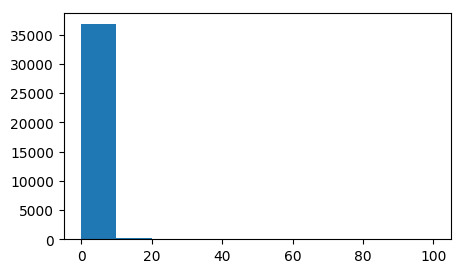

In [53]:
plt.figure(figsize=(5,3),dpi=100)
plt.hist(size.values, bins=10, range=[0,100])

It is clear that about `50%` of the restaurants have a unique category which is the combination of different type of food, style etc. i.e. Each of those categories are specific to that restaurant and do not repeat. Let's take a look at the some of the more common categories of the restaurants.

(array([279.,  73.,  31.,  12.,   9.,   8.,   6.,   5.,   5.,   8.]),
 array([ 10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91., 100.]),
 <a list of 10 Patch objects>)

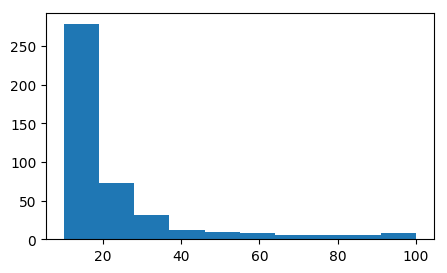

In [54]:
plt.figure(figsize=(5,3),dpi=100)
plt.hist(size.values, bins=10, range=[10,100])

Restaurant count by category

In [55]:
size.sort_values(ascending=False,inplace=True)
size

categories
Restaurants, Pizza                                                                   1042
Pizza, Restaurants                                                                   993 
Food, Coffee & Tea                                                                   888 
Mexican, Restaurants                                                                 885 
Coffee & Tea, Food                                                                   865 
                                                                                    ...  
Persian/Iranian, Mediterranean, Middle Eastern, Restaurants                          1   
Persian/Iranian, Middle Eastern, Restaurants                                         1   
Persian/Iranian, Middle Eastern, Restaurants, Caterers, Event Planning & Services    1   
Persian/Iranian, Middle Eastern, Restaurants, Food, Grocery                          1   
Acai Bowls, Bubble Tea, Food, Juice Bars & Smoothies                                 1   

In [56]:
size10 = size[size >= 10]
size10.sort_values(ascending=False,inplace=True)
size10

categories
Restaurants, Pizza                           1042
Pizza, Restaurants                           993 
Food, Coffee & Tea                           888 
Mexican, Restaurants                         885 
Coffee & Tea, Food                           865 
                                            ...  
Restaurants, Food, Mexican                   10  
Tex-Mex, Restaurants, Fast Food, Mexican     10  
Pakistani, Restaurants                       10  
Creperies, Restaurants                       10  
Delis, Fast Food, Restaurants, Sandwiches    10  
Length: 511, dtype: int64

In [57]:
size10.values

array([1042,  993,  888,  885,  865,  853,  840,  789,  492,  491,  474,
        446,  395,  386,  294,  282,  273,  272,  272,  264,  261,  256,
        254,  240,  235,  228,  227,  226,  220,  219,  217,  209,  198,
        193,  193,  190,  182,  181,  178,  175,  169,  168,  162,  158,
        157,  150,  142,  141,  136,  136,  135,  134,  133,  126,  125,
        125,  124,  124,  124,  120,  118,  112,  112,  112,  112,  111,
        111,  110,  107,  107,  105,  105,  104,  104,  102,   98,   98,
         98,   97,   96,   96,   94,   91,   90,   87,   85,   84,   84,
         80,   76,   75,   75,   74,   72,   72,   70,   70,   67,   65,
         63,   63,   61,   58,   57,   57,   56,   55,   54,   53,   52,
         50,   48,   48,   48,   48,   46,   44,   43,   42,   42,   42,
         39,   39,   39,   37,   37,   37,   37,   36,   35,   34,   34,
         34,   34,   33,   33,   33,   32,   32,   31,   31,   31,   31,
         31,   30,   30,   30,   29,   29,   29,   

In [58]:
pop = size.sum()
sample = size10.sum()
print('Number of records in the population: ' + str(pop))
print('Number of records in the subset: ' + str(sample))
print('The percentage of subset: ' + str(sample/pop))

Number of records in the population: 74555
Number of records in the subset: 29747
The percentage of subset: 0.39899403125209576


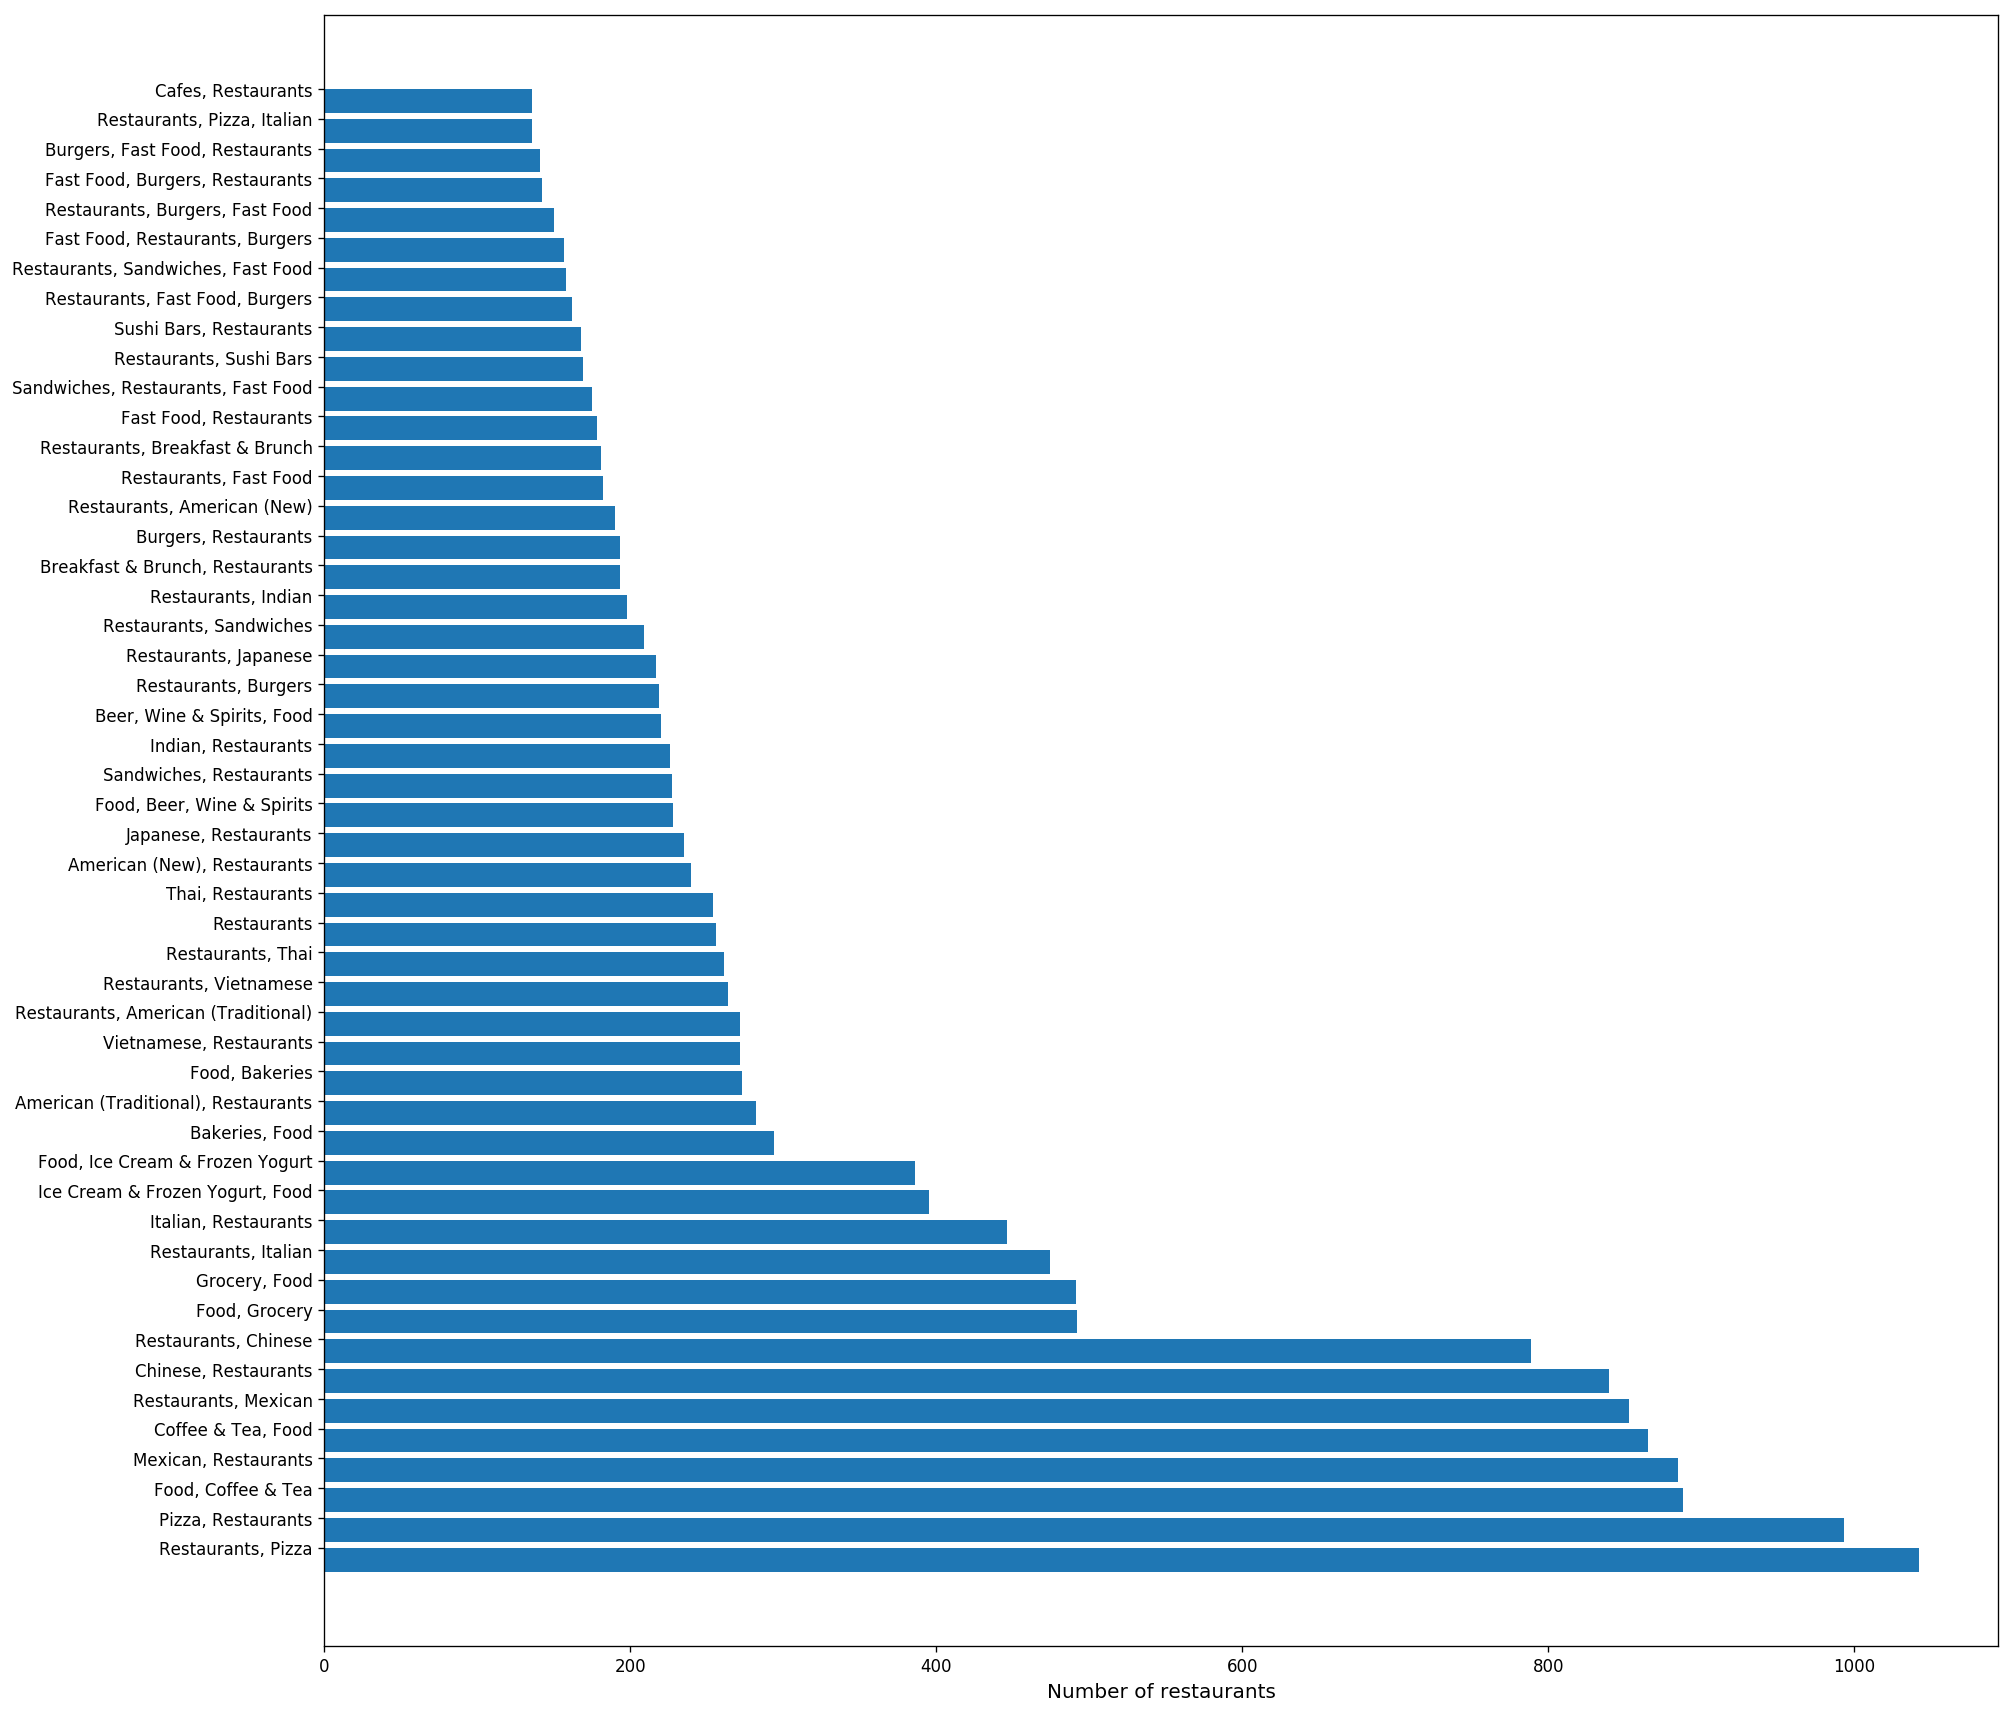

In [59]:
top50cat = size10[:50]
plt.figure(figsize=(18,18),dpi=120)
idx = [i for i in range(50)]
plt.barh(idx, top50cat.values)

ytics_label = []
for c in top50cat.index.values:
    ytics_label.append(''.join([i for i in c]))
    
plt.yticks([i + 0.4 for i in idx], ytics_label )
plt.xlabel('Number of restaurants', fontsize='large')
plt.show()

In [60]:
size10[:100]

categories
Restaurants, Pizza             1042
Pizza, Restaurants             993 
Food, Coffee & Tea             888 
Mexican, Restaurants           885 
Coffee & Tea, Food             865 
                              ...  
Mediterranean, Restaurants     70  
Restaurants, Asian Fusion      70  
Restaurants, Canadian (New)    67  
Food, Food Trucks              65  
Restaurants, Chicken Wings     63  
Length: 100, dtype: int64

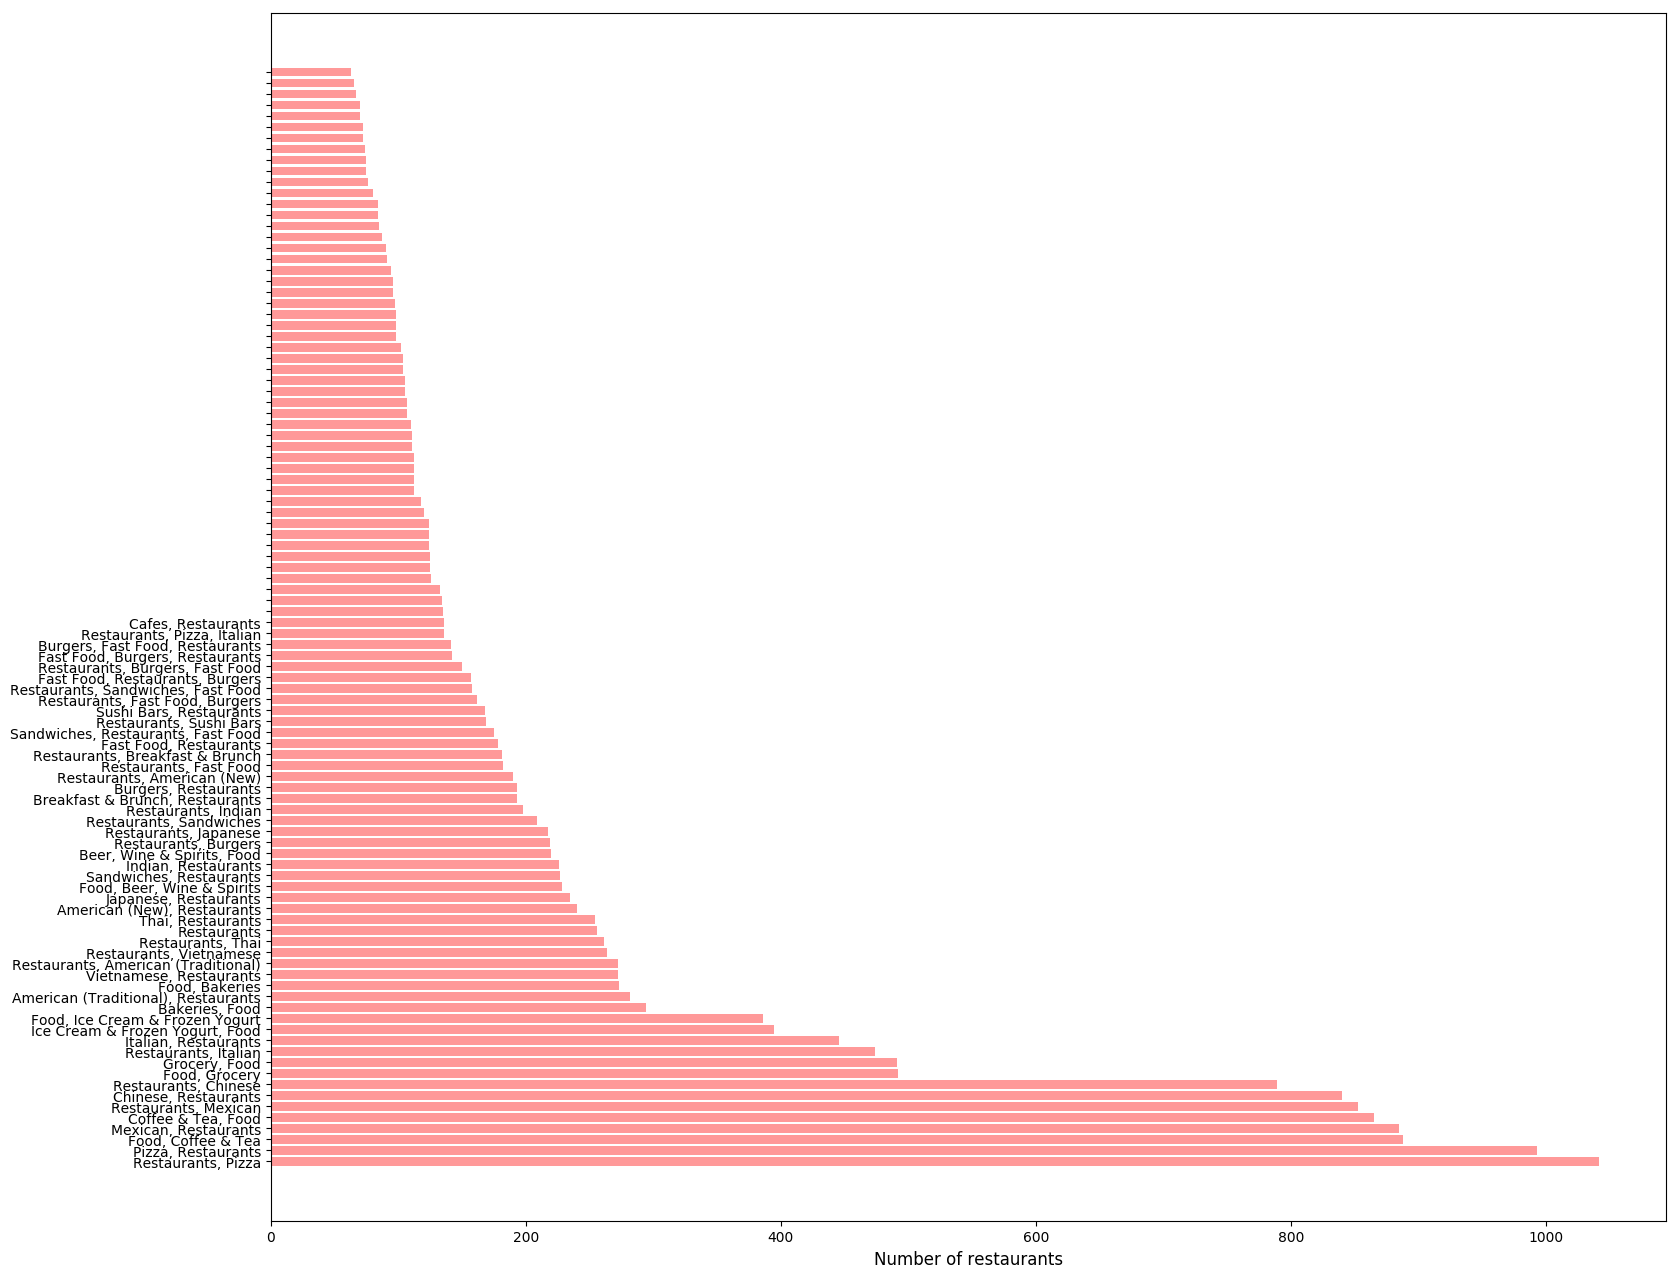

In [61]:
top100cat = size[:100]
plt.figure(figsize=(18,16),dpi=100)
idx = [i for i in range(100)]
plt.barh(idx, top100cat.values, color='#FF9999')

"""ytics_label = []
for c in top100cat.index.values:
    ytics_label.append(''.join([i for i in c]))
    """
plt.yticks([i for i in idx], ytics_label ) 
plt.xlabel('Number of restaurants', fontsize='large')
plt.show()

Use only top categories in the data

In [62]:
df_final_business = df_business_food[df_business_food.categories.isin(size10.index.values)]
df_final_business

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0
13,fweCYi8FmbJXHCqLnwuk8w,None,16,"Italian, Restaurants, Pizza, Chicken Wings",5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,41.708520,-81.359556,4.0
14,-K4gAv8_vjx8-2BxkVeRkA,Baby Cakes,7,"Bakeries, Food",4145 Erie St,Willoughby,OH,44094,41.639860,-81.406396,3.0
17,PZ-LZzSlhSe9utkQYU8pFg,None,40,"Restaurants, Italian","1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128528,4.0
26,C9oCPomVP0mtKa8z99E3gg,Bakery Gateau,8,"Bakeries, Food","865 York Mills Road, Unit 1",Toronto,ON,M3B 1Y6,43.754093,-79.349548,4.5
...,...,...,...,...,...,...,...,...,...,...,...
192585,3HAPJH0Qoi8Ix6M9rUMfjg,Indian Hero,39,"Restaurants, Indian",8920 Highway 50,Brampton,ON,L6P 3A3,43.775089,-79.653807,3.0
192587,oS0CnUbyv0GUoD3L8_3UPQ,Thai Fantasy,113,"Restaurants, Thai",578 Yonge Street,Toronto,ON,M4Y 1Z3,43.665120,-79.384809,4.0
192598,vIAEWbTJc657yN8I4z7whQ,Starbucks,138,"Food, Coffee & Tea","8164 S. Las Vegas Blvd., #100",Las Vegas,NV,89123,36.041407,-115.171698,3.0
192602,go-_xdHHSufchOeZ3kkC8w,Cedar Green Wine & Cheese,12,"Food, Beer, Wine & Spirits",2179 S Green Rd,University Heights,OH,44121,41.500621,-81.518241,3.0


In [63]:
print('The final version of business data has {} rows and {} columns.'.format(df_final_business.shape[0], df_final_business.shape[1]))

The final version of business data has 29747 rows and 11 columns.


In [64]:
print('The unique # of categories in the final business data is {}'.format(df_final_business.categories.nunique()))

The unique # of categories in the final business data is 511


## User

In [70]:
#reading user data from GCS bucket
df_user = pd.read_csv(csv_path_dict['user'])

In [71]:
print('The user data has {} rows and {} columns.'.format(df_user.shape[0], df_user.shape[1]))

The user data has 1637138 rows and 22 columns.


In [72]:
pd.set_option('display.max_colwidth', 50)
df_user.head(10)

,fans,compliment_cute,useful,name,user_id,compliment_list,compliment_profile,friends,compliment_photos,compliment_hot,compliment_more,compliment_cool,funny,compliment_writer,compliment_funny,compliment_plain,cool,review_count,compliment_note,average_stars,elite,yelping_since
0,5,0,84,b'Rashmi',b'l6BmjZMeQD3rDxWUbiAiow',0,0,"b'c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz...",0,2,0,1,17,2,1,1,25,95,1,4.03,"b'2015,2016,2017'",b'2013-10-08 23:11:33'
1,4,0,48,b'Jenna',b'4XChL029mKr5hydo79Ljxg',0,0,"b'kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGT...",0,1,0,1,22,0,1,0,16,33,0,3.63,b'',b'2013-02-21 22:29:06'
2,0,0,28,b'David',b'bc8C_eETBWL0olvFSJJd0w',0,0,"b'4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzM...",0,0,0,0,8,0,0,0,10,16,1,3.71,b'',b'2013-10-04 00:16:10'
3,5,0,30,b'Angela',b'dD0gZpBctWGdWo9WlGuhlA',0,0,"b'RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN...",0,1,0,0,4,1,0,2,14,17,0,4.85,b'',b'2014-05-22 15:57:30'
4,39,0,1114,b'Nancy',b'MM4RJAeH6yuaN8oZDSt0RA',1,0,"b'mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6D...",5,28,1,80,279,25,80,57,665,361,16,4.08,"b'2015,2016,2017,2018'",b'2013-10-23 07:02:50'
5,186,44,3475,b'Marilyn',b'0rK89TS8xqy1wI4nYI1wfw',3,50,"b'AJxDPGVTzefy3vSHWJchvQ, TgveR4qIsr0Q7b4MJK29...",195,350,46,483,2424,149,483,404,3048,214,221,4.20,"b'2015,2016,2017,2018'",b'2011-06-23 08:05:13'
6,696,889,13311,b'Keane',b'TEtzbpgA2BFBrC0y0sCbfw',152,333,"b'RJQTcJVlBsJ3_Yo0JSFQQg, GWt_h78k1CBBkE1NpThG...",428,5233,314,4991,19356,1086,4991,3635,15319,1122,1600,4.39,"b'2006,2007,2008,2009,2010,2011,2012,2013'",b'2006-02-15 18:29:35'
7,0,0,1,b'Andre',b'KGuqerdeNhxzXZEyBaqqSw',0,0,"b'd1z7Xc9RG5TVBkdUPhSbAw, IgsbGFEN8NWshPNOBiNG...",0,0,0,0,0,0,0,0,1,6,0,4.33,b'',b'2014-06-07 01:50:09'
8,57,7,1630,b'Tanya',b'T0gWkTHWRChVUe_Dn1F8nw',3,7,"b'ctr_BlCf3Ogny-vLs8E9tQ, c6HT44PKCaXqzN_BdgKP...",2,60,16,95,693,34,95,72,1244,859,31,4.21,"b'2006,2007,2008,2009,2010,2011,2012'",b'2005-07-20 22:38:17'
9,15,2,202,b'Trace',b'NQffx45eJaeqhFcMadKUQA',0,0,"b'N-xeG3U6rUkjVtQ0o-5YZA, wnO99pBbGqwqOoTQM25i...",5,13,3,14,70,3,14,8,185,124,12,4.53,b'',b'2008-12-10 22:59:45'


There are some encoding issues in the some of the columns in user dataset. lets fix this

In [73]:
# apply our cleaning function to each object column in the dataframe and assign back
for col in df_user.select_dtypes('object').columns:
    df_user[col] = df_user[col].apply(clean_byte_unicode_chars)

In [74]:
df_user.head()

,fans,compliment_cute,useful,name,user_id,compliment_list,compliment_profile,friends,compliment_photos,compliment_hot,compliment_more,compliment_cool,funny,compliment_writer,compliment_funny,compliment_plain,cool,review_count,compliment_note,average_stars,elite,yelping_since
0,5,0,84,Rashmi,l6BmjZMeQD3rDxWUbiAiow,0,0,"c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",0,2,0,1,17,2,1,1,25,95,1,4.03,"2015,2016,2017",2013-10-08 23:11:33
1,4,0,48,Jenna,4XChL029mKr5hydo79Ljxg,0,0,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",0,1,0,1,22,0,1,0,16,33,0,3.63,,2013-02-21 22:29:06
2,0,0,28,David,bc8C_eETBWL0olvFSJJd0w,0,0,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,0,0,0,8,0,0,0,10,16,1,3.71,,2013-10-04 00:16:10
3,5,0,30,Angela,dD0gZpBctWGdWo9WlGuhlA,0,0,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",0,1,0,0,4,1,0,2,14,17,0,4.85,,2014-05-22 15:57:30
4,39,0,1114,Nancy,MM4RJAeH6yuaN8oZDSt0RA,1,0,"mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",5,28,1,80,279,25,80,57,665,361,16,4.08,"2015,2016,2017,2018",2013-10-23 07:02:50


In [75]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637138 entries, 0 to 1637137
Data columns (total 22 columns):
fans                  1637138 non-null int64
compliment_cute       1637138 non-null int64
useful                1637138 non-null int64
name                  1636037 non-null object
user_id               1637138 non-null object
compliment_list       1637138 non-null int64
compliment_profile    1637138 non-null int64
friends               1637138 non-null object
compliment_photos     1637138 non-null int64
compliment_hot        1637138 non-null int64
compliment_more       1637138 non-null int64
compliment_cool       1637138 non-null int64
funny                 1637138 non-null int64
compliment_writer     1637138 non-null int64
compliment_funny      1637138 non-null int64
compliment_plain      1637138 non-null int64
cool                  1637138 non-null int64
review_count          1637138 non-null int64
compliment_note       1637138 non-null int64
average_stars         1637138

There is no null value in the user dataset. Create trimmed version of this dataframe.

In [76]:
df_final_user = df_user[['user_id','review_count','average_stars','yelping_since']]
df_final_user.head()

,user_id,review_count,average_stars,yelping_since
0,l6BmjZMeQD3rDxWUbiAiow,95,4.03,2013-10-08 23:11:33
1,4XChL029mKr5hydo79Ljxg,33,3.63,2013-02-21 22:29:06
2,bc8C_eETBWL0olvFSJJd0w,16,3.71,2013-10-04 00:16:10
3,dD0gZpBctWGdWo9WlGuhlA,17,4.85,2014-05-22 15:57:30
4,MM4RJAeH6yuaN8oZDSt0RA,361,4.08,2013-10-23 07:02:50


In [77]:
df_final_user['yelping_since'] = pd.to_datetime(df_final_user['yelping_since'])
df_final_user['yelping_age'] = (dt.datetime.now() - df_final_user['yelping_since']).abs()  / np.timedelta64(1, 'Y')
df_final_user['yelping_age'] = df_final_user['yelping_age'].fillna(0.0).astype(int)
df_final_user.head()

,user_id,review_count,average_stars,yelping_since,yelping_age
0,l6BmjZMeQD3rDxWUbiAiow,95,4.03,2013-10-08 23:11:33,6
1,4XChL029mKr5hydo79Ljxg,33,3.63,2013-02-21 22:29:06,7
2,bc8C_eETBWL0olvFSJJd0w,16,3.71,2013-10-04 00:16:10,6
3,dD0gZpBctWGdWo9WlGuhlA,17,4.85,2014-05-22 15:57:30,5
4,MM4RJAeH6yuaN8oZDSt0RA,361,4.08,2013-10-23 07:02:50,6


In [78]:
print('The final user dataset has {} rows and {} columns.'.format(df_final_user.shape[0], df_final_user.shape[1]))

The final user dataset has 1637138 rows and 5 columns.


## Review

In [79]:
#reading review data from GCS bucket
df_review = pd.read_csv(csv_path_dict['review'])

In [80]:
print('The review data has {} rows and {} columns.'.format(df_review.shape[0], df_review.shape[1]))

The review data has 6685900 rows and 9 columns.


In [81]:
df_review.head(10)

,useful,text,cool,business_id,date,stars,funny,user_id,review_id
0,6,b'Total bill for this horrible service? Over $...,0,b'ujmEBvifdJM6h6RLv4wQIg',b'2013-05-07 04:34:36',1.0,1,b'hG7b0MtEbXx5QzbzE6C_VA',b'Q1sbwvVQXV2734tPgoKj4Q'
1,0,"b""I *adore* Travis at the Hard Rock's new Kell...",0,b'NZnhc2sEQy3RmzKTZnqtwQ',b'2017-01-14 21:30:33',5.0,0,b'yXQM5uF2jS6es16SJzNHfg',b'GJXCdrto3ASJOqKeVWPi6Q'
2,3,"b""I have to say that this office really has it...",0,b'WTqjgwHlXbSFevF32_DJVw',b'2016-11-09 20:09:03',5.0,0,b'n6-Gk65cPZL6Uz8qRm3NYw',b'2TzJjDVDEuAW6MR5Vuc1ug'
3,0,"b""Went in for a lunch. Steak sandwich was deli...",0,b'ikCg8xy5JIg_NGPx-MSIDA',b'2018-01-09 20:56:38',5.0,0,b'dacAIZ6fTM6mqwW5uxkskg',b'yi0R0Ugj_xUx_Nek0-_Qig'
4,7,b'Today was my second out of three sessions I ...,0,b'b1b1eb3uo-w561D0ZfCEiQ',b'2018-01-30 23:07:38',1.0,0,b'ssoyf2_x0EQMed6fgHeMyQ',b'11a8sVPMUFtaC7_ABRkmtw'
5,0,b'I\'ll be the first to admit that I was not e...,0,b'eU_713ec6fTGNO4BegRaww',b'2013-01-20 13:25:59',4.0,0,b'w31MKYsNFMrjhWxxAb5wIw',b'fdiNeiN_hoCxCMy2wTRW9g'
6,5,"b""Tracy dessert had a big name in Hong Kong an...",5,b'3fw2X5bZYeW9xCz_zGhOHg',b'2016-05-07 01:21:02',3.0,4,b'jlu4CztcSxrKx56ba1a5AQ',b'G7XHMxG0bx9oBJNECG4IFg'
7,3,"b""This place has gone down hill. Clearly they...",1,b'zvO-PJCpNk4fgAVUnExYAA',b'2010-10-05 19:12:35',1.0,1,b'd6xvYpyzcfbF_AZ8vMB7QA',b'8e9HxxLjjqc9ez5ezzN7iQ'
8,1,b'I was really looking forward to visiting aft...,0,b'b2jN2mm9Wf3RcrZCgfo1cg',b'2015-01-18 14:04:18',2.0,0,b'sG_h0dIzTKWa3Q6fmb4u-g',b'qrffudO73zsslZbe8B9D3Q'
9,1,"b""It's a giant Best Buy with 66 registers. I ...",1,b'oxwGyA17NL6c5t1Etg5WgQ',b'2012-02-29 21:52:43',3.0,0,b'nMeCE5-xsdleyxYuNZ_7rA',b'RS_GTIT6836bCaPy637kNQ'


There are some encoding issues in `review text`, `business_id`, `user_id` and `review_id` columns. Lets fix this

In [82]:
# apply our cleaning function to each object column in the dataframe and assign back
for col in df_review.select_dtypes('object').columns:
    df_review[col] = df_review[col].apply(clean_byte_unicode_chars)

In [83]:
df_review.head(10)

,useful,text,cool,business_id,date,stars,funny,user_id,review_id
0,6,Total bill for this horrible service? Over $8G...,0,ujmEBvifdJM6h6RLv4wQIg,2013-05-07 04:34:36,1.0,1,hG7b0MtEbXx5QzbzE6C_VA,Q1sbwvVQXV2734tPgoKj4Q
1,0,None,0,NZnhc2sEQy3RmzKTZnqtwQ,2017-01-14 21:30:33,5.0,0,yXQM5uF2jS6es16SJzNHfg,GJXCdrto3ASJOqKeVWPi6Q
2,3,None,0,WTqjgwHlXbSFevF32_DJVw,2016-11-09 20:09:03,5.0,0,n6-Gk65cPZL6Uz8qRm3NYw,2TzJjDVDEuAW6MR5Vuc1ug
3,0,None,0,ikCg8xy5JIg_NGPx-MSIDA,2018-01-09 20:56:38,5.0,0,dacAIZ6fTM6mqwW5uxkskg,yi0R0Ugj_xUx_Nek0-_Qig
4,7,Today was my second out of three sessions I ha...,0,b1b1eb3uo-w561D0ZfCEiQ,2018-01-30 23:07:38,1.0,0,ssoyf2_x0EQMed6fgHeMyQ,11a8sVPMUFtaC7_ABRkmtw
5,0,I\'ll be the first to admit that I was not exc...,0,eU_713ec6fTGNO4BegRaww,2013-01-20 13:25:59,4.0,0,w31MKYsNFMrjhWxxAb5wIw,fdiNeiN_hoCxCMy2wTRW9g
6,5,None,5,3fw2X5bZYeW9xCz_zGhOHg,2016-05-07 01:21:02,3.0,4,jlu4CztcSxrKx56ba1a5AQ,G7XHMxG0bx9oBJNECG4IFg
7,3,None,1,zvO-PJCpNk4fgAVUnExYAA,2010-10-05 19:12:35,1.0,1,d6xvYpyzcfbF_AZ8vMB7QA,8e9HxxLjjqc9ez5ezzN7iQ
8,1,I was really looking forward to visiting after...,0,b2jN2mm9Wf3RcrZCgfo1cg,2015-01-18 14:04:18,2.0,0,sG_h0dIzTKWa3Q6fmb4u-g,qrffudO73zsslZbe8B9D3Q
9,1,None,1,oxwGyA17NL6c5t1Etg5WgQ,2012-02-29 21:52:43,3.0,0,nMeCE5-xsdleyxYuNZ_7rA,RS_GTIT6836bCaPy637kNQ


In [84]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685900 entries, 0 to 6685899
Data columns (total 9 columns):
useful         int64
text           object
cool           int64
business_id    object
date           object
stars          float64
funny          int64
user_id        object
review_id      object
dtypes: float64(1), int64(3), object(5)
memory usage: 459.1+ MB


Trim down the review dataset and use attributes that maybe helpful for analysis.

In [93]:
df_review_final = df_review[['business_id','review_id','user_id','text','useful']]
df_review_final.head()

,business_id,review_id,user_id,text,useful
0,ujmEBvifdJM6h6RLv4wQIg,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,Total bill for this horrible service? Over $8G...,6
1,NZnhc2sEQy3RmzKTZnqtwQ,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,None,0
2,WTqjgwHlXbSFevF32_DJVw,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,None,3
3,ikCg8xy5JIg_NGPx-MSIDA,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,None,0
4,b1b1eb3uo-w561D0ZfCEiQ,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,Today was my second out of three sessions I ha...,7


In [89]:
print('The trimmed version of review data has {} rows and {} columns.'.format(df_review_final.shape[0], df_review_trimmed.shape[1]))

The trimmed version of review data has 6685900 rows and 5 columns.


#### Merge trimmed version of review data with business data that contains only restaurant reviews

In [91]:
df_merged = pd.merge(df_final_business, df_review_final, how='left', on=['business_id'])
df_merged.head()

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars,review_id,user_id,text,useful
0,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,F7POrJsNbhu493DSTMPXjw,nsS4oDfOsl20QdWc6XcOkw,"Husband was craving Chicken Teriyaki & gyoza, ...",1.0
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,c-6aA9Bd7JxpmMroRoas9A,bK4Y_GZUoAUTXIrmeEUGYw,Went there Saturday noon they open at 12pm but...,0.0
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,P_MV_lMQjLIO9R7M_KIuMg,sbbB6Y4yIZIInvt0LFYYew,Went to this restaurant on Saturday as I had a...,1.0
3,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,dCLBdXP9tjjQG7EkHNeWzQ,hhQUVO2AqBdSeQcPo19Bsw,None,4.0
4,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,GiBx0zRVxC1Bu-9R-MMF8w,XSz4svDvgOCRO92V_3ajWg,"Well first time I\'ve really had ""authentic"" J...",0.0


In [96]:
print('The review and business merged data has {} rows and {} columns.'.format(df_merged.shape[0], df_merged.shape[1]))

The review and business merged data has 1122989 rows and 15 columns.


#### Looking at the merged review and business data, it contains many reviews marked as 'none' i.e. there is no review exists. We are taking a peek into those and will remove such records from our analysis.

In [97]:
df_merged = df_merged.dropna(subset = ['text'])
df_merged = df_merged[df_merged.text != "None"] #check trim, null

In [104]:
df_merged['text'].str.isspace().head()

0    False
1    False
2    False
4    False
6    False
Name: text, dtype: bool

In [102]:
print('After removing the empty review merged data has {} rows and {} columns.'.format(df_merged.shape[0], df_merged.shape[1]))

After removing the empty review merged data has 489834 rows and 15 columns.


In [103]:
df_merged.head()

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars,review_id,user_id,text,useful
0,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,F7POrJsNbhu493DSTMPXjw,nsS4oDfOsl20QdWc6XcOkw,"Husband was craving Chicken Teriyaki & gyoza, ...",1.0
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,c-6aA9Bd7JxpmMroRoas9A,bK4Y_GZUoAUTXIrmeEUGYw,Went there Saturday noon they open at 12pm but...,0.0
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,P_MV_lMQjLIO9R7M_KIuMg,sbbB6Y4yIZIInvt0LFYYew,Went to this restaurant on Saturday as I had a...,1.0
4,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,GiBx0zRVxC1Bu-9R-MMF8w,XSz4svDvgOCRO92V_3ajWg,"Well first time I\'ve really had ""authentic"" J...",0.0
6,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,170,"Sushi Bars, Restaurants, Japanese","10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,g0gMjs8Q1Dl5AxrM8QMiiA,7YeRMeb_cppMjjHAhT_k9A,First of all it must be said that this is a JA...,4.0


Write merged file into gcs bucket

In [ ]:
file_to_write = 'final_data'
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)
bucket.blob(file_to_write).upload_from_string(df_merged.to_csv(),'text/csv')

Create a stratified sampled dataset for manual labeling

In [123]:
df_stratified = df_merged.groupby('categories', group_keys=False).apply(lambda x: x.sample(int(np.rint(10000*len(x)/len(df_merged))))).sample(frac=1).reset_index(drop=True)
df_stratified.head(10)

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars,review_id,user_id,text,useful
0,Dsg1yPrT8JxqNOMQf5pt0Q,None,40,"Mexican, Restaurants",1480 E. Main St 85203,Mesa,AZ,85203,33.415527,-111.799083,3.5,HQJ8R-Na256PIjtrbO8x0Q,bmHvvSE0rIpmPUzkSyGWNQ,The meat here is horrible and the horchata is ...,3.0
1,B4fZ811vrsXDG30d3B3v3Q,None,76,"Restaurants, American (New)",5594 W Wild Horse Pass Blvd,Chandler,AZ,85226,33.265577,-111.993714,3.5,FvZ-DRziK6uHj-jp3R_evA,LbvtJc7hXl3OeranZZ_w2Q,I went to Ko\'Sin for restaurant week. The res...,3.0
2,-R2kwt0qMnzwEdAfXPvkXg,Udipi Cafe,308,"Pakistani, Indian, Restaurants",4141 Old William Penn Hwy,Monroeville,PA,15146,40.443403,-79.790422,4.0,i_G6m7kNUyI4HS7sjRlQtQ,3kj0naj7ACPcVdpnygFLEQ,The best And most authentic Udipi restaurant I...,0.0
3,Oi-u4KqrcZbIWSYKnh7mJA,Fortune Cookie II,83,"Chinese, Restaurants","8943 S Tryon St, Unit Q",Charlotte,NC,28273,35.136179,-80.936974,3.5,g6Sk3azrGXZN_Rx2K3tmCw,xByx_eS5LTjertNQ4tOR1g,Food tasted great but one of the pieces of chi...,0.0
4,U3dfIC7Zj8umDs__dDJl2Q,Thrifty Ice Cream,150,"Food, Ice Cream & Frozen Yogurt",2580 Wigwam Pkwy,Henderson,NV,89074,36.036066,-115.099731,4.0,U3RP4i42AN61JNY-O91liQ,206GEBKYDmRp2dygw3rTKw,Great prices and good selection of flavors. Th...,0.0
5,6M5WG1Hp38dsYkK77S-bzQ,Yogis Grill,57,"Restaurants, Asian Fusion","5104 N Dysart Rd, Ste 110",Litchfield Park,AZ,85340,33.509037,-112.341460,3.5,IniYhUIb3pmND6MsAQenbg,v1-joM8XrJNbImKIfAkk_A,Was in Litchfield Park for a conference and fo...,3.0
6,BQJokxJ4y4s57i7Mn65pvA,Hecho en Vegas,263,"Mexican, Restaurants",3799 Las Vegas Blvd S,Las Vegas,NV,89109,36.102251,-115.169968,3.5,Iytkc6DU2U8Y-rLHjtQ-Wg,2gtD_ED2iaT9jYMvQxfeBw,Great location and great guac made tableside. ...,0.0
7,UByM7N0mF-ylIGUuIWHCtA,None,258,"Steakhouses, Restaurants","1928 South Blvd, Ste 200",Charlotte,NC,28203,35.210168,-80.859931,4.0,BUrXm_JDVyiLcoT1DLGYPQ,ij0aK14SEUiBoqleSkOGxQ,"Had a limited availability item, a Wagyu cut. ...",0.0
8,NA7XJzFo9SfN-8KhTFv1bQ,K&B Sushi,125,"Japanese, Restaurants, Sushi Bars",2045 Winston Park Drive,Oakville,ON,L6H 6P5,43.508208,-79.668787,3.0,xPrwhKL2cdjzMNQRlRi6NA,Mn7R4GUVYbs6hT7ifV-EUg,It was very disappointed..\njust ordered the r...,1.0
9,hZLdSnk3cpp5R4tIxR9NzA,Rocket Fizz Soda Pop And Candy Shop,34,"Specialty Food, Food, Candy Stores","530 Euclid Ave, Ste 22B",Cleveland,OH,44115,41.499097,-81.689190,4.5,ETPWfW4aS2ujzPS808XzNw,GjvxjvjQa4TviKZDNnEs1A,An awesome store to check out if you are in th...,0.0


In [125]:
df_stratified.text = df_stratified.text.apply(fix_encoding)
df_stratified.head(10)

,business_id,name,review_count,categories,address,city,state,postal_code,latitude,longitude,stars,review_id,user_id,text,useful
0,Dsg1yPrT8JxqNOMQf5pt0Q,None,40,"Mexican, Restaurants",1480 E. Main St 85203,Mesa,AZ,85203,33.415527,-111.799083,3.5,HQJ8R-Na256PIjtrbO8x0Q,bmHvvSE0rIpmPUzkSyGWNQ,The meat here is horrible and the horchata is ...,3.0
1,B4fZ811vrsXDG30d3B3v3Q,None,76,"Restaurants, American (New)",5594 W Wild Horse Pass Blvd,Chandler,AZ,85226,33.265577,-111.993714,3.5,FvZ-DRziK6uHj-jp3R_evA,LbvtJc7hXl3OeranZZ_w2Q,I went to Ko'Sin for restaurant week. The reso...,3.0
2,-R2kwt0qMnzwEdAfXPvkXg,Udipi Cafe,308,"Pakistani, Indian, Restaurants",4141 Old William Penn Hwy,Monroeville,PA,15146,40.443403,-79.790422,4.0,i_G6m7kNUyI4HS7sjRlQtQ,3kj0naj7ACPcVdpnygFLEQ,The best And most authentic Udipi restaurant I...,0.0
3,Oi-u4KqrcZbIWSYKnh7mJA,Fortune Cookie II,83,"Chinese, Restaurants","8943 S Tryon St, Unit Q",Charlotte,NC,28273,35.136179,-80.936974,3.5,g6Sk3azrGXZN_Rx2K3tmCw,xByx_eS5LTjertNQ4tOR1g,Food tasted great but one of the pieces of chi...,0.0
4,U3dfIC7Zj8umDs__dDJl2Q,Thrifty Ice Cream,150,"Food, Ice Cream & Frozen Yogurt",2580 Wigwam Pkwy,Henderson,NV,89074,36.036066,-115.099731,4.0,U3RP4i42AN61JNY-O91liQ,206GEBKYDmRp2dygw3rTKw,Great prices and good selection of flavors. Th...,0.0
5,6M5WG1Hp38dsYkK77S-bzQ,Yogis Grill,57,"Restaurants, Asian Fusion","5104 N Dysart Rd, Ste 110",Litchfield Park,AZ,85340,33.509037,-112.341460,3.5,IniYhUIb3pmND6MsAQenbg,v1-joM8XrJNbImKIfAkk_A,Was in Litchfield Park for a conference and fo...,3.0
6,BQJokxJ4y4s57i7Mn65pvA,Hecho en Vegas,263,"Mexican, Restaurants",3799 Las Vegas Blvd S,Las Vegas,NV,89109,36.102251,-115.169968,3.5,Iytkc6DU2U8Y-rLHjtQ-Wg,2gtD_ED2iaT9jYMvQxfeBw,Great location and great guac made tableside. ...,0.0
7,UByM7N0mF-ylIGUuIWHCtA,None,258,"Steakhouses, Restaurants","1928 South Blvd, Ste 200",Charlotte,NC,28203,35.210168,-80.859931,4.0,BUrXm_JDVyiLcoT1DLGYPQ,ij0aK14SEUiBoqleSkOGxQ,"Had a limited availability item, a Wagyu cut. ...",0.0
8,NA7XJzFo9SfN-8KhTFv1bQ,K&B Sushi,125,"Japanese, Restaurants, Sushi Bars",2045 Winston Park Drive,Oakville,ON,L6H 6P5,43.508208,-79.668787,3.0,xPrwhKL2cdjzMNQRlRi6NA,Mn7R4GUVYbs6hT7ifV-EUg,It was very disappointed..\njust ordered the r...,1.0
9,hZLdSnk3cpp5R4tIxR9NzA,Rocket Fizz Soda Pop And Candy Shop,34,"Specialty Food, Food, Candy Stores","530 Euclid Ave, Ste 22B",Cleveland,OH,44115,41.499097,-81.689190,4.5,ETPWfW4aS2ujzPS808XzNw,GjvxjvjQa4TviKZDNnEs1A,An awesome store to check out if you are in th...,0.0


Write stratified sampled data into gcs bucket

In [126]:
file_to_write = 'stratified_sampled_data'
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)
bucket.blob(file_to_write).upload_from_string(df_stratified.head(2000).to_csv(),'text/csv')